In [ ]:
#!/usr/bin/env python3
"""
Perform EOF analysis on all ensemble members for a chosen CMIP6 model.
Works for annual-mean CMIP6 data with 2D latitude/longitude fields (dims j,i).

Author: Freja Klejnstrup
Date: 2025-10-28
"""

import xarray as xr
import numpy as np
import os
from eofs.xarray import Eof

# -----------------------------
# User settings
# -----------------------------
model = 'EC-Earth3'
base_dir = "/data/projects/nckf/frekle/CMIP6_data"
members = [f"r{i}i1p1f1" for i in range(1, 26)]  # r1–r25
variables = ['thetao', 'so']  # 3D temp and salinity
output_dir = f"/data/projects/nckf/frekle/EOF_results/{model}"
os.makedirs(output_dir, exist_ok=True)


# -----------------------------
# Helper functions
# -----------------------------

def load_surface_data(var, member):
    """Load 3D CMIP6 field and extract the surface layer (lev=0)."""
    file_path = f"{base_dir}/{var}/{var}_masked_{member}.nc"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Missing file: {file_path}")

    ds = xr.open_dataset(file_path)

    da = ds[var]
    # Extract surface (first depth level)
    if 'lev' in da.dims:
        da = da.isel(lev=0)

    # Subset time range if needed
    if 'time' in da.dims:
        da = da.sel(time=slice("1840", "2014"))

    # Attach coordinates
    if 'latitude' in ds and 'longitude' in ds:
        da = da.assign_coords(lat=ds['latitude'], lon=ds['longitude'])

    return da


def detrend_mean(da):
    """Remove long-term mean to obtain anomalies."""
    return da - da.mean('time')


def calculate_eof(da, n_modes=10):
    """Perform EOF analysis using eofs.xarray."""
    # Compute weights (area weighting with latitude)
    lat = da.lat
    if lat.ndim == 2:
        # Some CMIP6 models use 2D lat/lon fields
        lat_weights = np.sqrt(np.cos(np.deg2rad(lat)))
    else:
        lat_weights = np.sqrt(np.cos(np.deg2rad(lat)))[:, np.newaxis]

    solver = Eof(da, weights=lat_weights)

    eofs = solver.eofsAsCorrelation(neofs=n_modes)
    pcs = solver.pcs(npcs=n_modes, pcscaling=1)
    varfrac = solver.varianceFraction(neigs=n_modes)
    return eofs, pcs, varfrac


def save_eof_results(member, varname, eofs, pcs, varfrac):
    """Save EOF results to NetCDF file."""
    out = xr.Dataset({
        "EOFs": eofs,
        "PCs": pcs,
        "variance_fraction": varfrac
    })
    outfile = f"{output_dir}/EOF_{varname}_{member}.nc"
    out.to_netcdf(outfile)
    print(f"✅ Saved EOF results for {varname} {member} → {outfile}")


# -----------------------------
# Main loop
# -----------------------------
for member in members:
    print(f"\nProcessing ensemble member: {member}")

    for var in variables:
        try:
            da = load_surface_data(var, member)
            da_anom = detrend_mean(da)
            eofs, pcs, varfrac = calculate_eof(da_anom, n_modes=10)
            save_eof_results(member, var, eofs, pcs, varfrac)

        except Exception as e:
            print(f"⚠️ Skipped {var} {member} due to: {e}")
print("\nAll done!")


Processing ensemble member: r1i1p1f1
✅ Saved EOF results for thetao r1i1p1f1 → /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_thetao_r1i1p1f1.nc
✅ Saved EOF results for so r1i1p1f1 → /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_so_r1i1p1f1.nc

Processing ensemble member: r2i1p1f1
✅ Saved EOF results for thetao r2i1p1f1 → /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_thetao_r2i1p1f1.nc
✅ Saved EOF results for so r2i1p1f1 → /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_so_r2i1p1f1.nc

Processing ensemble member: r3i1p1f1
✅ Saved EOF results for thetao r3i1p1f1 → /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_thetao_r3i1p1f1.nc
✅ Saved EOF results for so r3i1p1f1 → /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_so_r3i1p1f1.nc

Processing ensemble member: r4i1p1f1
✅ Saved EOF results for thetao r4i1p1f1 → /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_thetao_r4i1p1f1.nc
✅ Saved EOF results for so r4i1p1f1 → /data/projects/nckf/frekle/EOF_resul

In [ ]:
#!/usr/bin/env python3
"""
Compare EOF modes across ensemble members for a given CMIP6 model.

Creates one large figure:
 ├── 3 rows (for 3 selected members)
 └── 4 columns: EOF1 | EOF2 | EOF3 | PCs (PC1–3 time series)

Also includes:
 - PC1 correlation matrix across all members
 - Explained variance summary
 - Decodes time to calendar years
 - Full Atlantic extent & geographic labels

Author: Freja Klejnstrup
Date: 2025-10-29
"""

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime

# -----------------------------
# User settings
# -----------------------------
model = "EC-Earth3"
varname = "thetao"  # change to "so" for salinity
base_dir = f"/data/projects/nckf/frekle/EOF_results/{model}"
members = [f"r{i}i1p1f1" for i in range(1, 26)]
plot_members = ["r1i1p1f1", "r6i1p1f1", "r10i1p1f1", "r17i1p1f1"]  # shown in the figure
n_modes = 3

# Output directory
fig_root = "/data/users/frekle/EOF/Figures"
fig_dir = os.path.join(fig_root, varname)
os.makedirs(fig_dir, exist_ok=True)
print(f"📁 Figures will be saved in: {fig_dir}")

# -----------------------------
# Helper functions
# -----------------------------
def load_eof_results(member, var):
    path = f"{base_dir}/EOF_{var}_{member}.nc"
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return xr.open_dataset(path)


def decode_time_to_years(time):
    if np.issubdtype(time.dtype, np.number) and "units" in time.attrs:
        try:
            tdt = cftime.num2date(time.values, units=time.attrs["units"],
                                  calendar=time.attrs.get("calendar", "gregorian"))
            return np.array([t.year + t.timetuple().tm_yday / 365.25 for t in tdt])
        except Exception:
            return np.arange(len(time))
    else:
        try:
            arr = xr.DataArray(time)
            return (arr.dt.year + arr.dt.dayofyear / 365.25).values
        except Exception:
            return np.arange(len(time))


def correlate_pc_time_series(pc_dict, mode=0):
    names = list(pc_dict.keys())
    n = len(names)
    corr = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            a = pc_dict[names[i]][:, mode]
            b = pc_dict[names[j]][:, mode]
            mask = np.isfinite(a) & np.isfinite(b)
            corr[i, j] = np.corrcoef(a[mask], b[mask])[0, 1]
    return corr, names


# -----------------------------
# Load EOFs, PCs, variance
# -----------------------------
eof_patterns, pcs, varfrac, times = {}, {}, {}, {}

for m in members:
    try:
        ds = load_eof_results(m, varname)
        eof_patterns[m] = ds["EOFs"].isel(mode=slice(0, n_modes))
        pcs[m] = ds["PCs"].values
        varfrac[m] = ds["variance_fraction"].values
        years = decode_time_to_years(ds["PCs"]["time"]) if "time" in ds["PCs"].coords else np.arange(pcs[m].shape[0])
        times[m] = years
    except Exception as e:
        print(f"⚠️ Skipping {m}: {e}")

print(f"✅ Loaded EOF results for {len(eof_patterns)} members.")

# -----------------------------
# -----------------------------
# 1️⃣ Big figure: EOF maps + PC plots (3×4)
# -----------------------------
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(len(plot_members), 4, width_ratios=[1, 1, 1, 1.2])

def draw_map(ax, field, lon, lat, title):
    pcm = ax.pcolormesh(lon, lat, field, transform=ccrs.PlateCarree(),
                        cmap="RdBu_r", shading="auto")
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=2)
    ax.set_extent([-100, 20, -60, 80])
    ax.set_xticks(np.arange(-100, 40, 20), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60, 90, 20), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.set_xlabel("Longitude (°E)", fontsize=9)
    ax.set_ylabel("Latitude (°N)", fontsize=9)
    ax.set_title(title, fontsize=9)
    return pcm

last_pcm = None
for i, member in enumerate(plot_members):
    if member not in eof_patterns:
        continue
    ds = eof_patterns[member]
    lon, lat = ds["longitude"], ds["latitude"]

    # --- Three Cartopy maps
    for mode in range(3):
        ax_map = fig.add_subplot(gs[i, mode], projection=ccrs.PlateCarree())
        title = f"EOF{mode+1} ({varfrac[member][mode]*100:.1f}%)"
        last_pcm = draw_map(ax_map, ds.isel(mode=mode), lon, lat, title)

    # --- One normal plot for PCs
    ax_pc = fig.add_subplot(gs[i, 3])
    for mode in range(3):
        ax_pc.plot(times[member], pcs[member][:, mode],
                   label=f"PC{mode+1}", lw=1.2)
    ax_pc.set_xlim(times[member][0], times[member][-1])
    ax_pc.set_xticks(np.arange(1850, 2020, 20))
    ax_pc.set_xlabel("Year")
    ax_pc.set_ylabel("Amplitude (a.u.)")
    ax_pc.set_title(f"{member} PCs", fontsize=9)
    ax_pc.grid(True, linestyle="--", alpha=0.4)
    if i == 0:
        ax_pc.legend(fontsize=8, loc="upper right")

# Shared colorbar
cax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
fig.colorbar(last_pcm, cax=cax, label="EOF amplitude (°C)")

plt.suptitle(f"{model} {varname.upper()} | EOF Modes 1–3 + PCs (4 members)", fontsize=15)
plt.subplots_adjust(wspace=0.3, hspace=0.25, right=0.9, top=0.93, bottom=0.05)
plt.savefig(f"{fig_dir}/EOF_PCs_{varname}_4members_combined.png", dpi=300)
plt.close()
print("✅ Saved combined EOF+PC figure (4×4 grid).")


# -----------------------------
# 2️⃣ PC1 time series (all members + ensemble mean)
# -----------------------------
plt.figure(figsize=(12, 6))

# Collect PC1s into an aligned matrix
pc1_matrix = []
min_len = min(pcs[m].shape[0] for m in pcs.keys())
common_time = None

for member in pcs.keys():
    # Truncate to minimum length for safe averaging
    pc1 = pcs[member][:min_len, 0]
    pc1_matrix.append(pc1)
    if common_time is None:
        common_time = times[member][:min_len]
    plt.plot(times[member][:min_len], pc1, color='gray', alpha=0.4, lw=1)

# Ensemble mean
pc1_mean = np.mean(pc1_matrix, axis=0)
plt.plot(common_time, pc1_mean, color='black', lw=2.5, label='Ensemble mean')

# Plot styling
plt.title(f"{model} {varname.upper()} | PC1 Time Series Across Members")
plt.xlabel("Year")
plt.ylabel("PC1 (a.u.)")
plt.xticks(np.arange(1850, 2020, 20))
plt.legend(frameon=False)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(f"{fig_dir}/PC1_timeseries_{varname}.png", dpi=300)
plt.close()
print("✅ Saved PC1 time series comparison plot (with ensemble mean).")

# -----------------------------
# 3️⃣ Explained variance (mean ± std)
# -----------------------------
var_table = np.array([varfrac[m][:3] for m in pcs.keys()])
mean_var = var_table.mean(axis=0)
std_var = var_table.std(axis=0)

plt.figure(figsize=(8, 5))
x = np.arange(1, 4)
plt.bar(x, mean_var*100, yerr=std_var*100, capsize=5)
plt.xticks(x, [f"EOF{i}" for i in x])
plt.ylabel("Explained Variance (%)")
plt.title(f"{model} {varname.upper()} | Mean Explained Variance (±1σ)")
plt.tight_layout()
plt.savefig(f"{fig_dir}/explained_variance_{varname}.png", dpi=300)
plt.close()
print("✅ Saved explained variance summary.")






📁 Figures will be saved in: /data/users/frekle/EOF/Figures/thetao
⚠️ Skipping r22i1p1f1: /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_thetao_r22i1p1f1.nc
⚠️ Skipping r23i1p1f1: /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_thetao_r23i1p1f1.nc
⚠️ Skipping r25i1p1f1: /data/projects/nckf/frekle/EOF_results/EC-Earth3/EOF_thetao_r25i1p1f1.nc
✅ Loaded EOF results for 22 members.
✅ Saved combined EOF+PC figure (4×4 grid).
✅ Saved PC1 time series comparison plot (with ensemble mean).
✅ Saved explained variance summary.


### spatial correlation between each of its EOF

In [ ]:
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

# =====================================================
# Helper: spatial correlation between two EOF patterns
# =====================================================
def pattern_corr(eof1, eof2):
    """Compute spatial correlation between two EOFs."""
    a = eof1.values.flatten()
    b = eof2.values.flatten()
    mask = np.isfinite(a) & np.isfinite(b)
    a, b = a[mask], b[mask]
    if len(a) < 3:
        return np.nan
    return np.corrcoef(a, b)[0, 1]


# =====================================================
# Main alignment function
# =====================================================
def align_eofs_from_files(
    data_dir,
    varname="thetao",
    ref_member="r1i1p1f1",
    plot_corr=True,
    save_aligned=True,
    n_modes_to_plot=None
):
    """
    Align EOF signs and order across ensemble members.
    Displays correlation matrices and saves aligned files
    in a dedicated 'aligned/' folder.
    
    Parameters
    ----------
    data_dir : str
        Directory containing EOF result files.
    varname : str
        Variable name (used in filenames, e.g. 'thetao').
    ref_member : str
        Reference ensemble member (e.g. 'r1i1p1f1').
    plot_corr : bool
        Whether to display correlation matrices.
    save_aligned : bool
        Whether to save aligned EOF/PC files.
        
    Returns
    -------
    aligned_eofs : dict[str, xr.DataArray]
    aligned_pcs : dict[str, xr.DataArray]
    """
    # -------------------------------------------------
    # Find EOF files
    # -------------------------------------------------
    file_pattern = os.path.join(data_dir, f"EOF_{varname}_r*.nc")
    files = sorted(glob.glob(file_pattern))
    if not files:
        raise FileNotFoundError(f"No files found in {data_dir} matching pattern 'EOF_{varname}_r*.nc'")
    
    print(f"📂 Found {len(files)} EOF files:")
    for f in files:
        print("   ", os.path.basename(f))
    
    # -------------------------------------------------
    # Load datasets
    # -------------------------------------------------
    eofs_dict, pcs_dict = {}, {}
    for f in files:
        member = os.path.basename(f).split("_")[-1].replace(".nc", "")
        ds = xr.open_dataset(f)
        eofs_dict[member] = ds["EOFs"]
        pcs_dict[member] = ds["PCs"]

    ref_eofs = eofs_dict[ref_member]
    n_modes = ref_eofs.sizes["mode"]
    
    aligned_eofs, aligned_pcs = {}, {}
    
    # -------------------------------------------------
    # Prepare save directory
    # -------------------------------------------------
    if save_aligned:
        aligned_dir = os.path.join(data_dir, "aligned")
        os.makedirs(aligned_dir, exist_ok=True)
        print(f"📁 Aligned files will be saved to: {aligned_dir}\n")
    
    # -------------------------------------------------
    # Loop through members
    # -------------------------------------------------
    for member, eofs in eofs_dict.items():
        pcs = pcs_dict[member].copy()
        
        if member == ref_member:
            aligned_eofs[member] = eofs
            aligned_pcs[member] = pcs
            continue
        
        # Compute correlation matrix
        corr_matrix = np.zeros((n_modes, n_modes))
        for i in range(n_modes):
            for j in range(n_modes):
                corr_matrix[i, j] = pattern_corr(ref_eofs.isel(mode=i), eofs.isel(mode=j))
        
        # Determine best match
        best_match = np.argmax(np.abs(corr_matrix), axis=0)
        
        # Reorder + sign flip
        reordered_eofs = eofs.isel(mode=best_match)
        reordered_pcs = pcs[:, best_match]
        for m in range(n_modes):
            corr = corr_matrix[m, best_match[m]]
            if corr < 0:
                reordered_eofs[m] *= -1
                reordered_pcs[:, m] *= -1
        
        aligned_eofs[member] = reordered_eofs
        aligned_pcs[member] = reordered_pcs
        
        print(f"✅ Aligned {member}: reordered as {best_match + 1}, sign-corrected where needed.")
        
        # -------------------------------------------------
        # Show correlation matrix (no saving)
        if plot_corr:
            # Limit the number of modes to plot
            nm = n_modes_to_plot or n_modes  # use full if not specified
            corr_plot = corr_matrix[:nm, :nm]

            fig, ax = plt.subplots(figsize=(5.5, 4.5))
            im = ax.imshow(corr_plot, cmap="RdBu_r", vmin=-1, vmax=1)
            plt.colorbar(im, ax=ax, label="Correlation coefficient")
            ax.set_title(f"{member} vs {ref_member}\nEOF correlation matrix", fontsize=12)
            ax.set_xlabel(f"{member} EOF modes")
            ax.set_ylabel(f"Reference ({ref_member}) EOF modes")
            ax.set_xticks(range(nm))
            ax.set_xticklabels(range(1, nm + 1))
            ax.set_yticks(range(nm))
            ax.set_yticklabels(range(1, nm + 1))
            plt.tight_layout()
            plt.show()
        
        # -------------------------------------------------
        # Save aligned files in new folder
        # -------------------------------------------------
        if save_aligned:
            out_path = os.path.join(aligned_dir, f"EOF_{varname}_{member}_aligned.nc")
            xr.Dataset({"EOFs": reordered_eofs, "PCs": reordered_pcs}).to_netcdf(out_path)
            print(f"💾 Saved aligned file: {out_path}\n")
    
    print("🎯 All EOF modes are now aligned and saved.")
    return aligned_eofs, aligned_pcs


# ------------------------------------------------------------
# 6. Load AMOC streamfunction files
# ------------------------------------------------------------
amoc_dir = "/data/projects/nckf/frekle/CMIP6_data/msftyz"
files_amoc = sorted(glob.glob(os.path.join(amoc_dir, "msftyz_Oyear_EC-Earth3_historical_r*i1p1f1_gn_185001-201412_Atl.nc")))
print(f"🌊 Found {len(files_amoc)} AMOC files")

amoc_dict = {}
for f in files_amoc:
    member = os.path.basename(f).split("_")[4]  # extract r1i1p1f1
    ds = xr.open_dataset(f)
    amoc_dict[member] = ds["msftyz"]

# ------------------------------------------------------------
# 7. Compute ensemble mean AMOC field
# ------------------------------------------------------------
all_amoc = xr.concat([amoc_dict[m] for m in amoc_dict], dim="member")
all_amoc["member"] = list(amoc_dict.keys())

amoc_mean = all_amoc.mean(dim="member")
amoc_std  = all_amoc.std(dim="member")

print("✅ Computed ensemble mean and std of AMOC streamfunction")

# ------------------------------------------------------------
# 8. Plot ensemble mean AMOC streamfunction (latitude–depth)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))
im = ax.contourf(
    amoc_mean["rlat"], amoc_mean["lev"], amoc_mean.mean(dim="time"),
    levels=20, cmap="RdBu_r"
)
ax.invert_yaxis()
ax.set_xlabel("Latitude (°N)")
ax.set_ylabel("Depth (m)")
plt.colorbar(im, ax=ax, label="Mean AMOC Streamfunction [kg s⁻¹]")
ax.set_title("Ensemble Mean AMOC (Time Mean)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9. Plot AMOC strength evolution at chosen lat/depth
# ------------------------------------------------------------
lat_sel = 26   # degrees North
depth_sel = 500  # meters

# Find closest grid points
lat_idx = np.abs(amoc_mean["rlat"] - lat_sel).argmin()
lev_idx = np.abs(amoc_mean["lev"] - depth_sel).argmin()

# Extract time series for each member
amoc_strength = []
for m, da in amoc_dict.items():
    series = da.isel(rlat=lat_idx, lev=lev_idx)
    amoc_strength.append(series)
amoc_strength = xr.concat(amoc_strength, dim="member")
amoc_strength["member"] = list(amoc_dict.keys())

amoc_mean_strength = amoc_strength.mean(dim="member")

# Plot spaghetti + mean
fig, ax = plt.subplots(figsize=(10, 5))
for m in amoc_dict.keys():
    ax.plot(amoc_strength["time"], amoc_strength.sel(member=m), color="gray", alpha=0.5)

ax.plot(amoc_mean_strength["time"], amoc_mean_strength, color="red", lw=2, label="Ensemble mean")
ax.set_title(f"AMOC Strength at {lat_sel}° N, {depth_sel} m", fontsize=13)
ax.set_xlabel("Time")
ax.set_ylabel("Streamfunction [kg s⁻¹]")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"🎯 Plotted AMOC mean structure and strength at {lat_sel}° N, {depth_sel} m")




📂 Found 22 EOF files:
    EOF_thetao_r10i1p1f1.nc
    EOF_thetao_r11i1p1f1.nc
    EOF_thetao_r12i1p1f1.nc
    EOF_thetao_r13i1p1f1.nc
    EOF_thetao_r14i1p1f1.nc
    EOF_thetao_r15i1p1f1.nc
    EOF_thetao_r16i1p1f1.nc
    EOF_thetao_r17i1p1f1.nc
    EOF_thetao_r18i1p1f1.nc
    EOF_thetao_r19i1p1f1.nc
    EOF_thetao_r1i1p1f1.nc
    EOF_thetao_r20i1p1f1.nc
    EOF_thetao_r21i1p1f1.nc
    EOF_thetao_r24i1p1f1.nc
    EOF_thetao_r2i1p1f1.nc
    EOF_thetao_r3i1p1f1.nc
    EOF_thetao_r4i1p1f1.nc
    EOF_thetao_r5i1p1f1.nc
    EOF_thetao_r6i1p1f1.nc
    EOF_thetao_r7i1p1f1.nc
    EOF_thetao_r8i1p1f1.nc
    EOF_thetao_r9i1p1f1.nc
📁 Aligned files will be saved to: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned

✅ Aligned r10i1p1f1: reordered as [1 2 5 4 5 6 8 9 8 8], sign-corrected where needed.


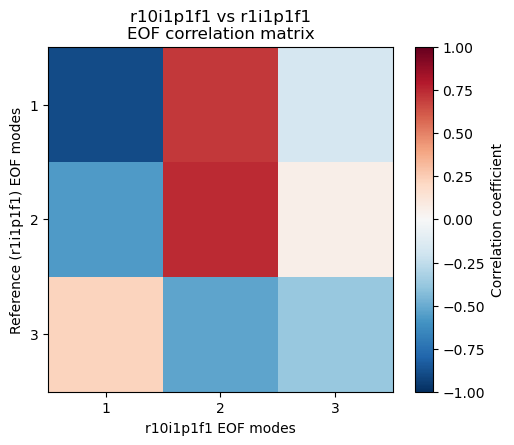

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r10i1p1f1_aligned.nc

✅ Aligned r11i1p1f1: reordered as [ 1  2  5  4  5  6  8  7  8 10], sign-corrected where needed.


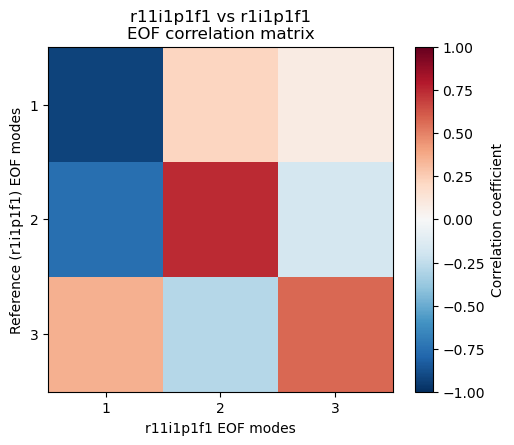

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r11i1p1f1_aligned.nc

✅ Aligned r12i1p1f1: reordered as [ 1  2  4  5  8  6  6 10  8  3], sign-corrected where needed.


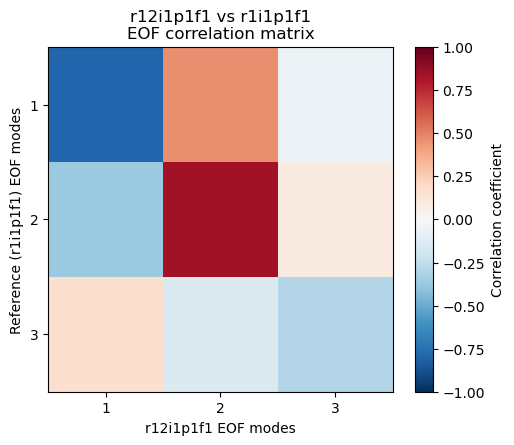

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r12i1p1f1_aligned.nc

✅ Aligned r13i1p1f1: reordered as [ 1  2  3  4  5  6  6  8  7 10], sign-corrected where needed.


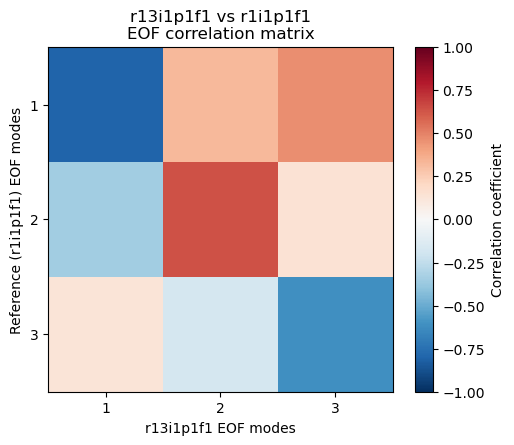

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r13i1p1f1_aligned.nc

✅ Aligned r14i1p1f1: reordered as [1 2 3 3 8 5 6 5 3 7], sign-corrected where needed.


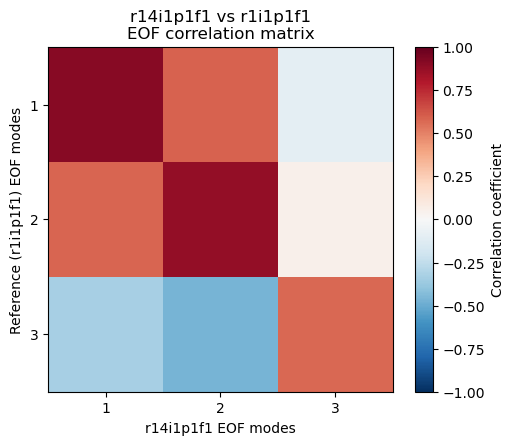

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r14i1p1f1_aligned.nc

✅ Aligned r15i1p1f1: reordered as [ 1  2  3  4  5  6  8  7 10  9], sign-corrected where needed.


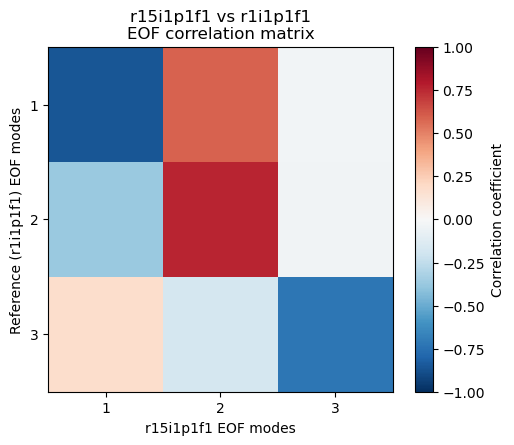

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r15i1p1f1_aligned.nc

✅ Aligned r16i1p1f1: reordered as [ 1  5  3  5  4 10  8  6  8  2], sign-corrected where needed.


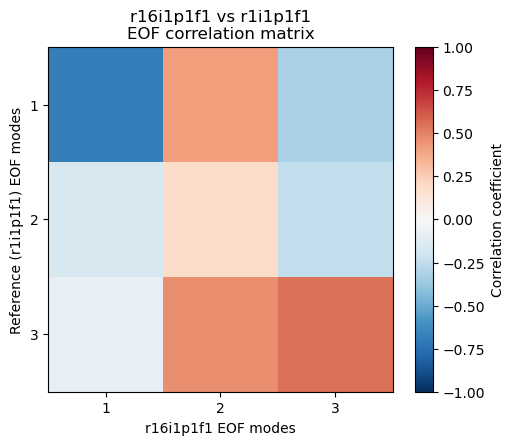

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r16i1p1f1_aligned.nc

✅ Aligned r17i1p1f1: reordered as [1 4 4 5 5 6 8 8 8 9], sign-corrected where needed.


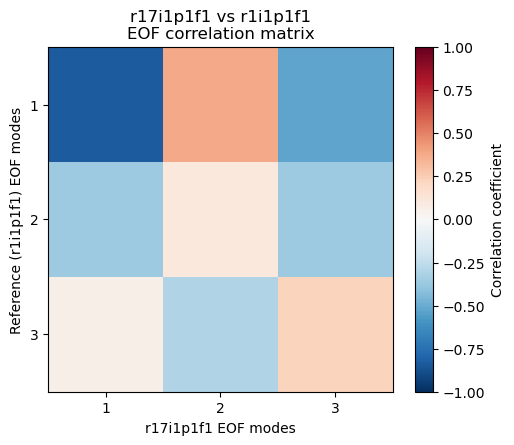

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r17i1p1f1_aligned.nc

✅ Aligned r18i1p1f1: reordered as [1 3 2 4 8 5 6 7 8 7], sign-corrected where needed.


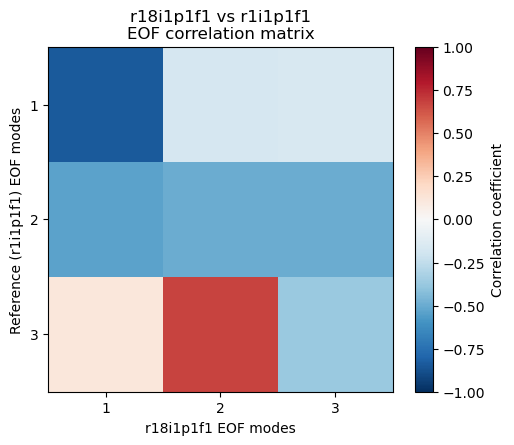

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r18i1p1f1_aligned.nc

✅ Aligned r19i1p1f1: reordered as [2 2 3 5 4 8 6 8 6 9], sign-corrected where needed.


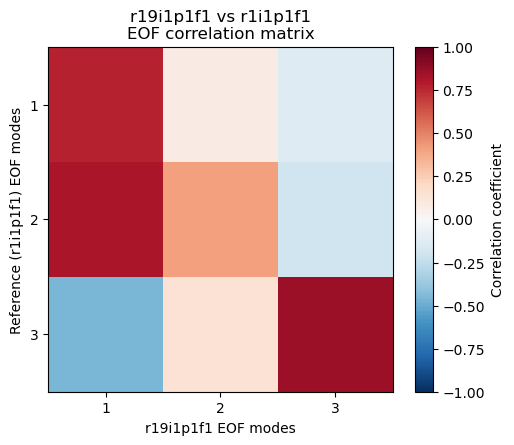

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r19i1p1f1_aligned.nc

✅ Aligned r20i1p1f1: reordered as [ 1  3  2  5  4  5  8 10  5  7], sign-corrected where needed.


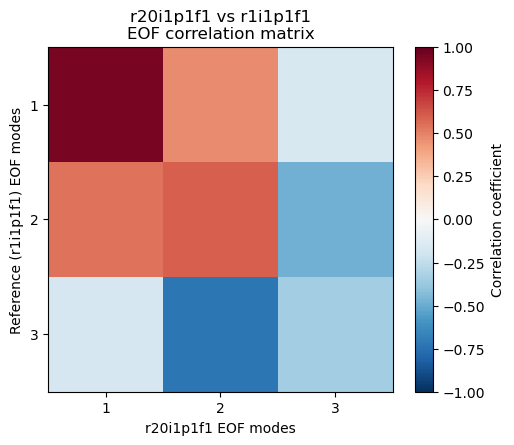

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r20i1p1f1_aligned.nc

✅ Aligned r21i1p1f1: reordered as [1 2 3 5 4 8 8 6 4 7], sign-corrected where needed.


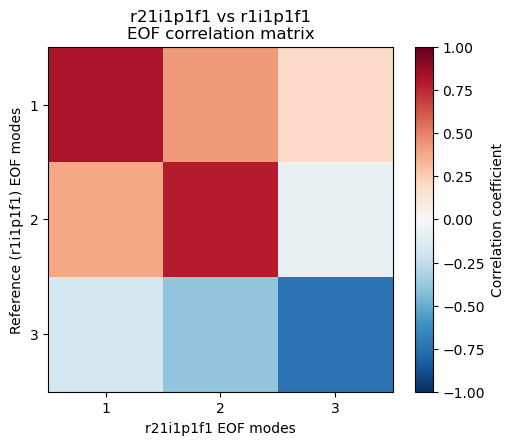

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r21i1p1f1_aligned.nc

✅ Aligned r24i1p1f1: reordered as [ 5  1  4  5  5  8  8  6  8 10], sign-corrected where needed.


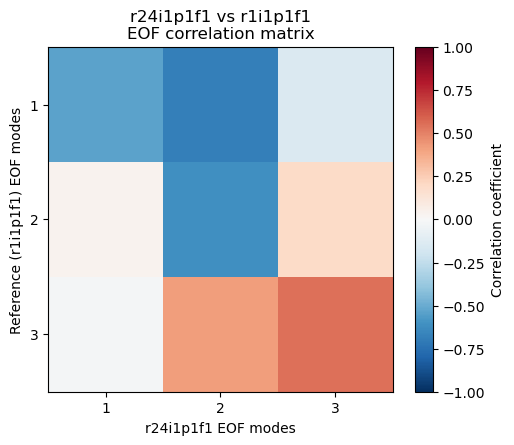

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r24i1p1f1_aligned.nc

✅ Aligned r2i1p1f1: reordered as [1 2 3 6 6 5 8 7 8 3], sign-corrected where needed.


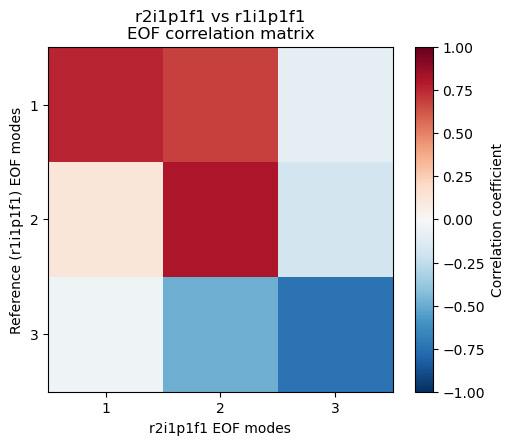

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r2i1p1f1_aligned.nc

✅ Aligned r3i1p1f1: reordered as [ 1  1  3  5  5  6  8  8  8 10], sign-corrected where needed.


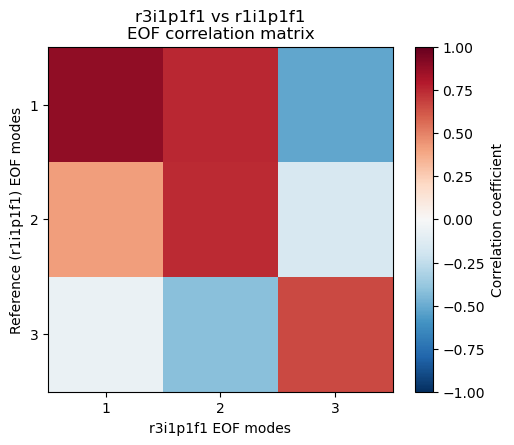

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r3i1p1f1_aligned.nc

✅ Aligned r4i1p1f1: reordered as [ 1  5  1  1  5  6  8  8  8 10], sign-corrected where needed.


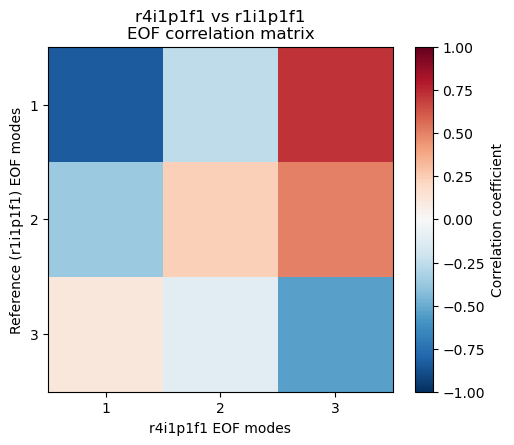

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r4i1p1f1_aligned.nc

✅ Aligned r5i1p1f1: reordered as [1 2 4 6 5 8 8 7 9 9], sign-corrected where needed.


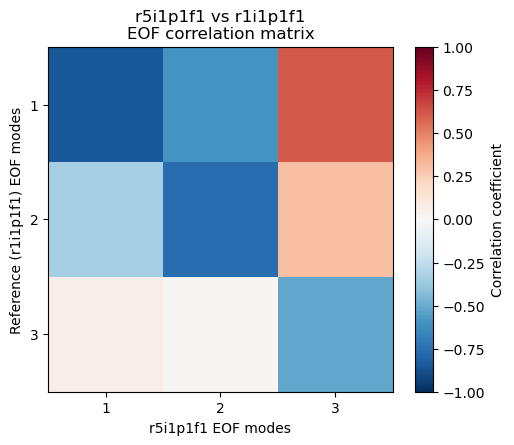

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r5i1p1f1_aligned.nc

✅ Aligned r6i1p1f1: reordered as [ 1  3  4  4  5  6 10  8  3  8], sign-corrected where needed.


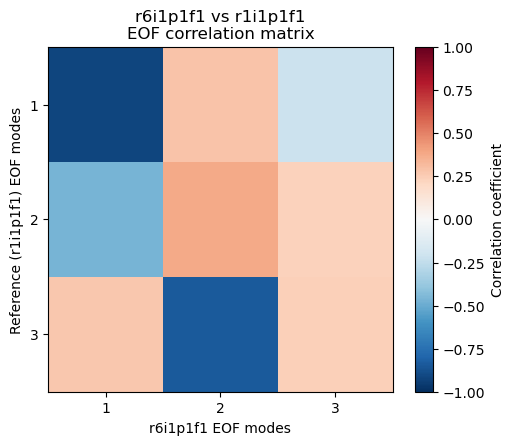

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r6i1p1f1_aligned.nc

✅ Aligned r7i1p1f1: reordered as [1 2 3 4 5 6 8 6 8 7], sign-corrected where needed.


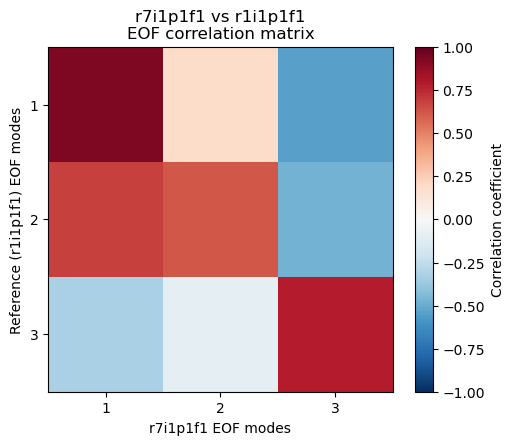

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r7i1p1f1_aligned.nc

✅ Aligned r8i1p1f1: reordered as [1 2 3 3 5 6 8 7 5 6], sign-corrected where needed.


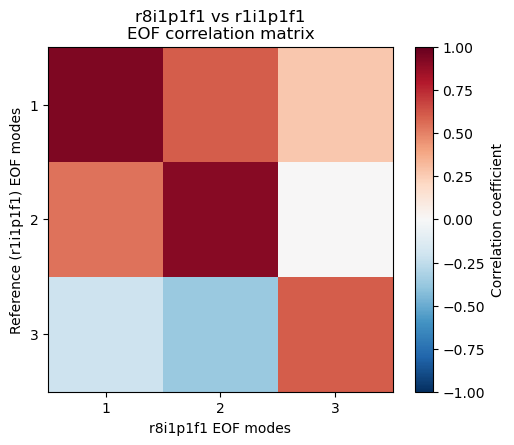

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r8i1p1f1_aligned.nc

✅ Aligned r9i1p1f1: reordered as [1 5 4 3 5 6 8 3 7 8], sign-corrected where needed.


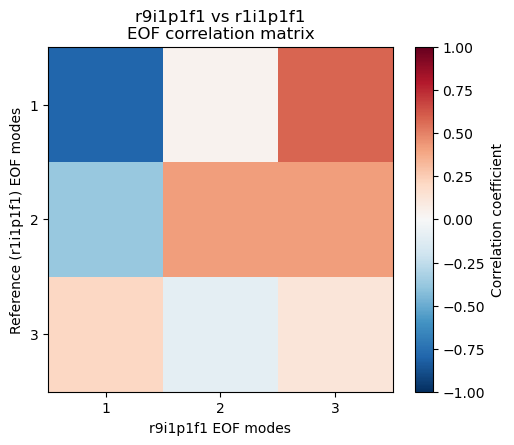

💾 Saved aligned file: /data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned/EOF_thetao_r9i1p1f1_aligned.nc

🎯 All EOF modes are now aligned and saved.


In [8]:
aligned_eofs, aligned_pcs = align_eofs_from_files(
    data_dir="/data/projects/nckf/frekle/EOF_results/EC-Earth3",
    varname="thetao",
    ref_member="r1i1p1f1",
    plot_corr=True,
    save_aligned=True,
    n_modes_to_plot=3  # 👈 Only show first 3 EOF modes in the plot
)




In [9]:
import os
import glob
import xarray as xr

# ---------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------
SRC_BASE = "/dmidata/projects/nckf/cmip6/historical/EC-Earth3"
DEST_BASE = "/data/projects/nckf/frekle/CMIP6_data/msftyz/Atl"

# Create output folder if it doesn't exist
os.makedirs(DEST_BASE, exist_ok=True)

print("🌊 Extracting Atlantic basin (basin=1) from EC-Earth3 AMOC files...")
print(f"Saving to: {DEST_BASE}\n")

# ---------------------------------------------------------------
# Loop through all ensemble members
# ---------------------------------------------------------------
members = sorted(glob.glob(os.path.join(SRC_BASE, "r*i1p1f1")))

for member_path in members:
    member = os.path.basename(member_path)
    src_file = os.path.join(
        member_path,
        "Oyear",
        "msftyz",
        f"msftyz_Oyear_EC-Earth3_historical_{member}_gn_185001-201412.nc"
    )
    dest_file = os.path.join(
        DEST_BASE,
        f"msftyz_Oyear_EC-Earth3_historical_{member}_gn_185001-201412_Atl.nc"
    )

    if not os.path.exists(src_file):
        print(f"⚠️  Missing file for {member}, skipped.")
        continue

    try:
        ds = xr.open_dataset(src_file)

        if "basin" in ds.dims:
            # Select basin index 1 (Atlantic)
            da = ds["msftyz"].isel(basin=1)
        else:
            print(f"⚠️  No 'basin' dimension in {member}, copying as-is.")
            da = ds["msftyz"]

        # Drop basin coordinate and save
        da.to_netcdf(dest_file)
        print(f"✅ Saved Atlantic-only file for {member}:")
        print(f"   {dest_file}\n")

        ds.close()

    except Exception as e:
        print(f"❌ Error processing {member}: {e}\n")

print("🎯 Done! All Atlantic files saved in:")
print(f"   {DEST_BASE}")


🌊 Extracting Atlantic basin (basin=1) from EC-Earth3 AMOC files...
Saving to: /data/projects/nckf/frekle/CMIP6_data/msftyz/Atl

✅ Saved Atlantic-only file for r10i1p1f1:
   /data/projects/nckf/frekle/CMIP6_data/msftyz/Atl/msftyz_Oyear_EC-Earth3_historical_r10i1p1f1_gn_185001-201412_Atl.nc

✅ Saved Atlantic-only file for r11i1p1f1:
   /data/projects/nckf/frekle/CMIP6_data/msftyz/Atl/msftyz_Oyear_EC-Earth3_historical_r11i1p1f1_gn_185001-201412_Atl.nc

✅ Saved Atlantic-only file for r12i1p1f1:
   /data/projects/nckf/frekle/CMIP6_data/msftyz/Atl/msftyz_Oyear_EC-Earth3_historical_r12i1p1f1_gn_185001-201412_Atl.nc

✅ Saved Atlantic-only file for r13i1p1f1:
   /data/projects/nckf/frekle/CMIP6_data/msftyz/Atl/msftyz_Oyear_EC-Earth3_historical_r13i1p1f1_gn_185001-201412_Atl.nc

✅ Saved Atlantic-only file for r14i1p1f1:
   /data/projects/nckf/frekle/CMIP6_data/msftyz/Atl/msftyz_Oyear_EC-Earth3_historical_r14i1p1f1_gn_185001-201412_Atl.nc

✅ Saved Atlantic-only file for r15i1p1f1:
   /data/projec

📂 Found 21 aligned EOF files
✅ Computed ensemble mean EOFs


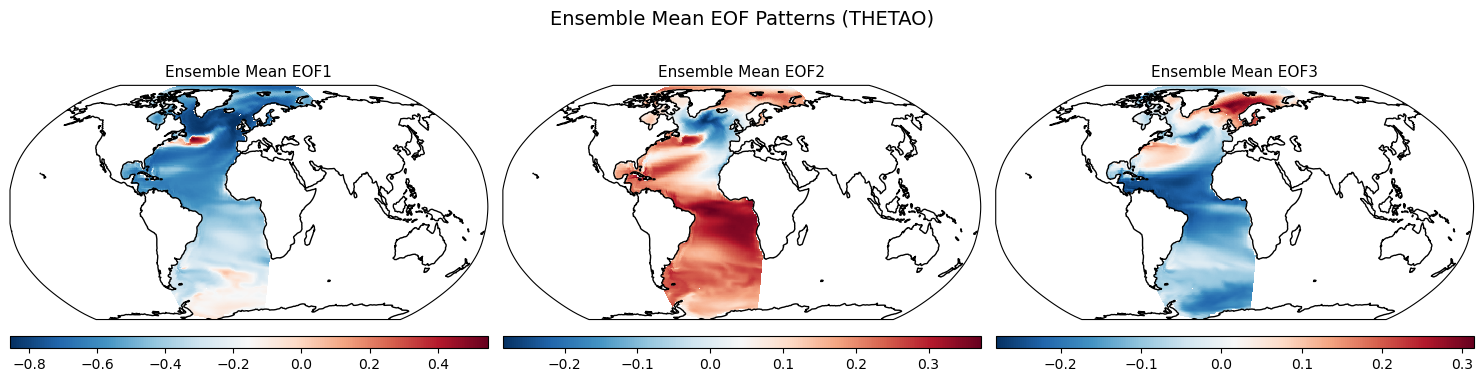

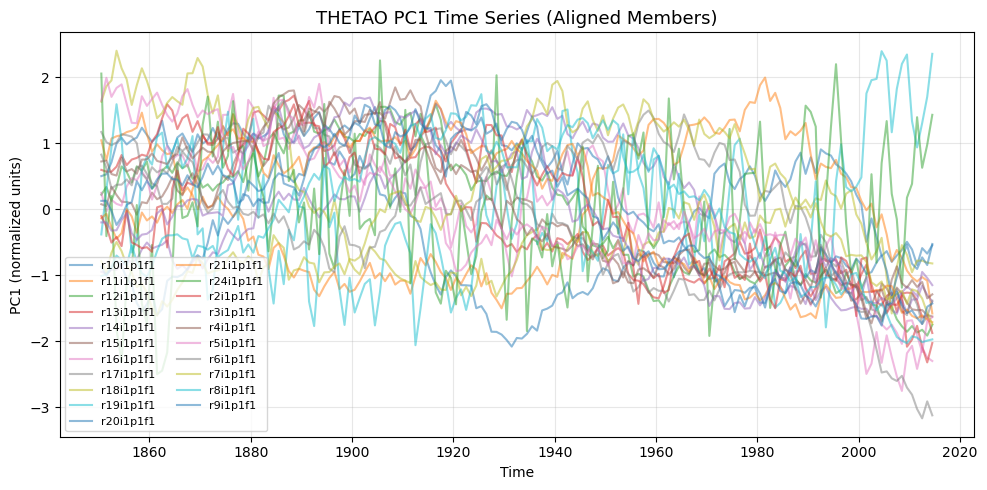

<Figure size 640x480 with 0 Axes>

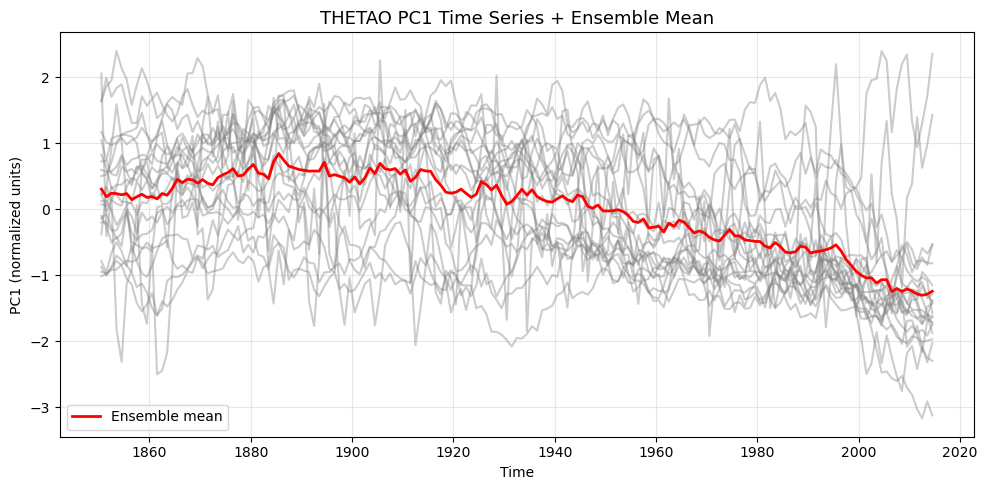

🌊 Found 25 AMOC Atlantic files


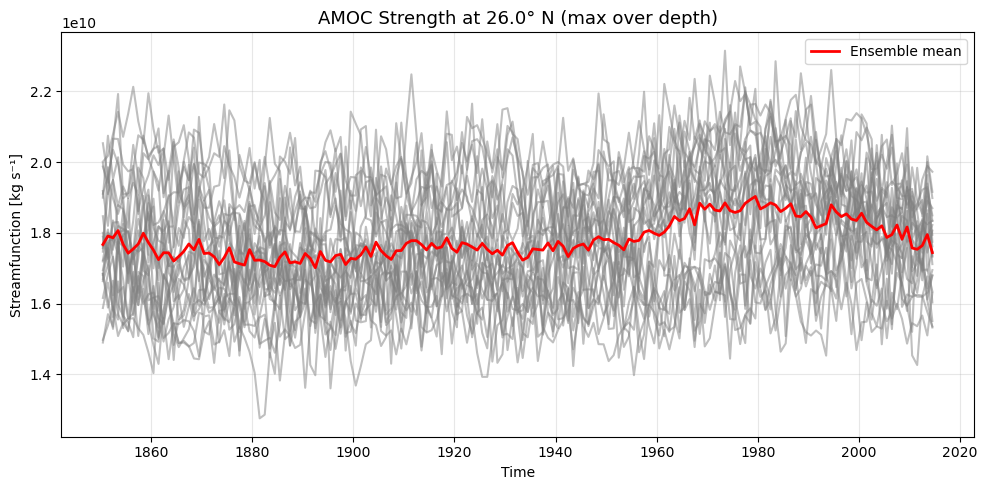

r10i1p1f1: r = -0.737, p = 1.638e-29
r11i1p1f1: r = -0.738, p = 1.061e-29
r12i1p1f1: r = -0.660, p = 5.167e-22
r13i1p1f1: r = -0.625, p = 3.139e-19
r14i1p1f1: r = -0.839, p = 5.762e-45
r15i1p1f1: r = -0.707, p = 2.744e-26
r16i1p1f1: r = -0.498, p = 1.047e-11
r17i1p1f1: r = -0.794, p = 4.347e-37
r18i1p1f1: r = -0.652, p = 2.377e-21
r19i1p1f1: r = -0.118, p = 1.312e-01
r20i1p1f1: r = -0.756, p = 7.565e-32
r21i1p1f1: r = -0.764, p = 8.320e-33
r24i1p1f1: r = 0.067, p = 3.912e-01
r2i1p1f1: r = -0.331, p = 1.420e-05
r3i1p1f1: r = -0.691, p = 1.010e-24
r4i1p1f1: r = -0.724, p = 4.446e-28
r5i1p1f1: r = -0.739, p = 8.703e-30
r6i1p1f1: r = -0.625, p = 3.003e-19
r7i1p1f1: r = -0.801, p = 3.145e-38
r8i1p1f1: r = -0.754, p = 1.555e-31
r9i1p1f1: r = -0.792, p = 8.402e-37

📊 Mean correlation across members: r = -0.632


In [17]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy.stats as st
from tqdm.notebook import tqdm

# ===========================================================
# 1. Load ALIGNED EOFs and PCs
# ===========================================================
aligned_dir = "/data/projects/nckf/frekle/EOF_results/EC-Earth3/aligned"
varname = "thetao"

files = sorted(glob.glob(os.path.join(aligned_dir, f"EOF_{varname}_r*_aligned.nc")))
print(f"📂 Found {len(files)} aligned EOF files")

eofs_dict, pcs_dict = {}, {}
for f in files:
    member = os.path.basename(f).split("_")[-2]
    ds = xr.open_dataset(f)
    eofs_dict[member] = ds["EOFs"]
    pcs_dict[member] = ds["PCs"]

# ===========================================================
# 2. Compute ensemble mean EOF patterns
# ===========================================================
# Ensure 'mode' is just a positional dimension (no problematic coordinates)
cleaned = []
for m in eofs_dict:
    da = eofs_dict[m]
    if "mode" in da.coords:
        da = da.reset_index("mode", drop=True)
        da = da.assign_coords(mode=np.arange(da.sizes["mode"]))
    cleaned.append(da)

all_eofs = xr.concat(cleaned, dim="member")
all_eofs["member"] = list(eofs_dict.keys())

mean_eofs = all_eofs.mean(dim="member")
std_eofs = all_eofs.std(dim="member")
print("✅ Computed ensemble mean EOFs")

# -----------------------------------------------------------
# Plot ensemble-mean EOF patterns (modes 1–3)
# -----------------------------------------------------------
example_ds = xr.open_dataset(files[0])
lat, lon = example_ds["lat"], example_ds["lon"]

modes_to_plot = [0, 1, 2]
proj = ccrs.Robinson(central_longitude=0)
fig, axes = plt.subplots(1, len(modes_to_plot), figsize=(15, 4),
                         subplot_kw={"projection": proj})

for i, mode in enumerate(modes_to_plot):
    ax = axes[i]
    eof = mean_eofs.isel(mode=mode)
    im = ax.pcolormesh(lon, lat, eof, cmap="RdBu_r",
                       transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f"Ensemble Mean EOF{mode+1}", fontsize=11)
    plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, aspect=40)

plt.suptitle(f"Ensemble Mean EOF Patterns ({varname.upper()})", fontsize=14)
plt.tight_layout()
plt.show()

fig.savefig(f"/data/users/frekle/EOF/Figures/thetao/Aligned/Ensemble_Mean_EOFs_{varname}.png", dpi=300)


# ===========================================================
# 3. Plot PC1 time series (spaghetti plot)
# ===========================================================
fig, ax = plt.subplots(figsize=(10, 5))

for member, pcs in pcs_dict.items():
    ax.plot(pcs["time"], pcs[:, 0], alpha=0.5, lw=1.5, label=member)

ax.set_title(f"{varname.upper()} PC1 Time Series (Aligned Members)", fontsize=13)
ax.set_xlabel("Time")
ax.set_ylabel("PC1 (normalized units)")
ax.grid(alpha=0.3)
ax.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

plt.savefig(f"/data/users/frekle/EOF/Figures/thetao/Aligned/PC1_timeseries_{varname}_spaghetti.png", dpi=300)

# -----------------------------------------------------------
# Add ensemble-mean PC1
# -----------------------------------------------------------
pc1_all = xr.concat([pcs[:, 0] for pcs in pcs_dict.values()], dim="member")
pc1_all["member"] = list(pcs_dict.keys())
pc1_mean = pc1_all.mean(dim="member")

fig, ax = plt.subplots(figsize=(10, 5))
for member, pcs in pcs_dict.items():
    ax.plot(pcs["time"], pcs[:, 0], color="gray", alpha=0.4)
ax.plot(pc1_mean["time"], pc1_mean, color="red", lw=2, label="Ensemble mean")
ax.set_title(f"{varname.upper()} PC1 Time Series + Ensemble Mean", fontsize=13)
ax.set_xlabel("Time")
ax.set_ylabel("PC1 (normalized units)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig.savefig(f"/data/users/frekle/EOF/Figures/thetao/Aligned/PC1_timeseries_{varname}_ensemble_mean.png", dpi=300)   


# ===========================================================
# 4. Load AMOC data (Atlantic-only files)
# ===========================================================
amoc_dir = "/data/projects/nckf/frekle/CMIP6_data/msftyz/Atl"
amoc_files = sorted(glob.glob(os.path.join(amoc_dir, "msftyz_Oyear_EC-Earth3_historical_r*_Atl.nc")))
print(f"🌊 Found {len(amoc_files)} AMOC Atlantic files")

amoc_dict = {}
for f in amoc_files:
    member = os.path.basename(f).split("_")[4]
    ds = xr.open_dataset(f)
    amoc_dict[member] = ds["msftyz"]

# ===========================================================
# 5. Compute AMOC strength (max over depth at 26°N)
# ===========================================================
lat_sel = 26.0

# pick closest latitude index from first member
ref_member = list(amoc_dict.keys())[0]
lat_idx = np.abs(amoc_dict[ref_member]["rlat"] - lat_sel).argmin()

amoc_strength = []
for m, da in amoc_dict.items():
    s = da.isel(rlat=lat_idx).max("lev")  # max over depth
    amoc_strength.append(s)
amoc_strength = xr.concat(amoc_strength, dim="member")
amoc_strength["member"] = list(amoc_dict.keys())

amoc_mean_strength = amoc_strength.mean(dim="member")

# -----------------------------------------------------------
# Plot AMOC strength spaghetti
# -----------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))
for m in amoc_dict.keys():
    ax.plot(amoc_strength["time"], amoc_strength.sel(member=m), color="gray", alpha=0.5)
ax.plot(amoc_mean_strength["time"], amoc_mean_strength, color="red", lw=2, label="Ensemble mean")
ax.set_title(f"AMOC Strength at {lat_sel}° N (max over depth)", fontsize=13)
ax.set_xlabel("Time")
ax.set_ylabel("Streamfunction [kg s⁻¹]")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save plot at /data/users/frekle/EOF/Figures/thetao/Aligned/AMOC_strength_26N.png
fig.savefig("/data/users/frekle/EOF/Figures/thetao/Aligned/AMOC_strength_26N.png", dpi=300)

# 6. Correlate PC1 with AMOC strength
# ===========================================================
rs, ps = [], []
for m in amoc_dict.keys():
    if m not in pcs_dict:
        continue
    pc1 = pcs_dict[m][:, 0].values
    amoc_series = amoc_strength.sel(member=m).values
    mask = np.isfinite(pc1) & np.isfinite(amoc_series)
    if mask.sum() > 3:
        r, p = st.pearsonr(pc1[mask], amoc_series[mask])
        rs.append(r)
        ps.append(p)
        print(f"{m}: r = {r:.3f}, p = {p:.3e}")

# Ensemble-mean correlation
if len(rs) > 0:
    r_mean = np.nanmean(rs)
    print(f"\n📊 Mean correlation across members: r = {r_mean:.3f}")
else:
    print("No overlapping members for correlation.")


In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def analyze_eof_alignment(aligned_eofs, ref_member='r1i1p1f1', n_modes=3, plot=True):
    """
    Diagnose EOF alignment across ensemble members.
    Prints which modes were swapped or sign-flipped
    and optionally plots correlation matrices.
    """
    ref_eofs = aligned_eofs[ref_member]
    members = list(aligned_eofs.keys())

    print(f"\n🔍 EOF Alignment Diagnostics (reference = {ref_member})")
    print("------------------------------------------------------------")

    for member in members:
        if member == ref_member:
            continue

        eofs = aligned_eofs[member]
        corr_matrix = np.zeros((n_modes, n_modes))
        for i in range(n_modes):
            for j in range(n_modes):
                a = ref_eofs.isel(mode=i).values.flatten()
                b = eofs.isel(mode=j).values.flatten()
                mask = np.isfinite(a) & np.isfinite(b)
                if mask.sum() < 3:
                    corr_matrix[i, j] = np.nan
                else:
                    corr_matrix[i, j] = np.corrcoef(a[mask], b[mask])[0, 1]

        # Find best matches
        best_match = np.argmax(np.abs(corr_matrix), axis=0)

        # Detect swaps and sign flips
        swaps, sign_flips = [], []
        for j in range(n_modes):
            i = best_match[j]
            r = corr_matrix[i, j]
            if i != j:
                swaps.append(f"{j+1}↔{i+1}")
            if r < 0:
                sign_flips.append(f"{j+1}")

        # ---- Text summary ----
        mapping = ", ".join([f"{j+1}→{best_match[j]+1}" for j in range(n_modes)])
        print(f"🧩 {member}: Mode mapping [{mapping}]")
        if swaps:
            print(f"   🔄 Swapped modes: {', '.join(swaps)}")
        if sign_flips:
            print(f"   🔃 Sign flipped: EOF {', '.join(sign_flips)}")
        if not swaps and not sign_flips:
            print("   ✅ Perfect alignment with reference")
        print("------------------------------------------------------------")


# Example call (after running your alignment)
analyze_eof_alignment(aligned_eofs, ref_member='r1i1p1f1', n_modes=5, plot=True)




🔍 EOF Alignment Diagnostics (reference = r1i1p1f1)
------------------------------------------------------------
🧩 r10i1p1f1: Mode mapping [1→1, 2→2, 3→5, 4→4, 5→5]
   🔄 Swapped modes: 3↔5
------------------------------------------------------------
🧩 r11i1p1f1: Mode mapping [1→1, 2→2, 3→5, 4→4, 5→5]
   🔄 Swapped modes: 3↔5
------------------------------------------------------------
🧩 r12i1p1f1: Mode mapping [1→1, 2→2, 3→5, 4→3, 5→5]
   🔄 Swapped modes: 3↔5, 4↔3
   🔃 Sign flipped: EOF 4
------------------------------------------------------------
🧩 r13i1p1f1: Mode mapping [1→1, 2→2, 3→3, 4→4, 5→5]
   ✅ Perfect alignment with reference
------------------------------------------------------------
🧩 r14i1p1f1: Mode mapping [1→1, 2→2, 3→3, 4→3, 5→5]
   🔄 Swapped modes: 4↔3
------------------------------------------------------------
🧩 r15i1p1f1: Mode mapping [1→1, 2→2, 3→3, 4→4, 5→5]
   ✅ Perfect alignment with reference
------------------------------------------------------------
🧩 r16i1

In [18]:
import os
import subprocess

target_dir = "/data/projects/nckf/frekle/obs_data"
os.makedirs(target_dir, exist_ok=True)
os.chdir(target_dir)

base_url = "http://www.metoffice.gov.uk/hadobs/en4/data/en4-2-1/EN.4.2.2"

for year in range(1900, 2026):
    fname = f"EN.4.2.2.analyses.c14.{year}.zip"
    url = f"{base_url}/{fname}"
    print(f"⬇️ Downloading {year} ...")
    subprocess.run(["wget", "-q", "-O", fname, url])
    subprocess.run(["unzip", "-o", fname], stdout=subprocess.DEVNULL)
    os.remove(fname)

print("✅ All EN4 analysis files downloaded and extracted.")


⬇️ Downloading 1900 ...
⬇️ Downloading 1901 ...
⬇️ Downloading 1902 ...
⬇️ Downloading 1903 ...
⬇️ Downloading 1904 ...
⬇️ Downloading 1905 ...
⬇️ Downloading 1906 ...
⬇️ Downloading 1907 ...
⬇️ Downloading 1908 ...
⬇️ Downloading 1909 ...
⬇️ Downloading 1910 ...
⬇️ Downloading 1911 ...
⬇️ Downloading 1912 ...
⬇️ Downloading 1913 ...
⬇️ Downloading 1914 ...
⬇️ Downloading 1915 ...
⬇️ Downloading 1916 ...
⬇️ Downloading 1917 ...
⬇️ Downloading 1918 ...
⬇️ Downloading 1919 ...
⬇️ Downloading 1920 ...
⬇️ Downloading 1921 ...
⬇️ Downloading 1922 ...
⬇️ Downloading 1923 ...
⬇️ Downloading 1924 ...
⬇️ Downloading 1925 ...
⬇️ Downloading 1926 ...
⬇️ Downloading 1927 ...
⬇️ Downloading 1928 ...
⬇️ Downloading 1929 ...
⬇️ Downloading 1930 ...
⬇️ Downloading 1931 ...
⬇️ Downloading 1932 ...
⬇️ Downloading 1933 ...
⬇️ Downloading 1934 ...
⬇️ Downloading 1935 ...
⬇️ Downloading 1936 ...
⬇️ Downloading 1937 ...
⬇️ Downloading 1938 ...
⬇️ Downloading 1939 ...
⬇️ Downloading 1940 ...
⬇️ Downloading 1

  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of EN.4.2.2.analyses.c14.2022.zip or
        EN.4.2.2.analyses.c14.2022.zip.zip, and cannot find EN.4.2.2.analyses.c14.2022.zip.ZIP, period.
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of EN.4.2.2.analyses.c14.2023.zip or
        EN.4.2.2.analyses.c14.2023.zip.zip, and cannot find EN.4.2.2.analyses.c14.2023.zip.ZIP, period.


⬇️ Downloading 2024 ...
⬇️ Downloading 2025 ...
✅ All EN4 analysis files downloaded and extracted.


  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of EN.4.2.2.analyses.c14.2024.zip or
        EN.4.2.2.analyses.c14.2024.zip.zip, and cannot find EN.4.2.2.analyses.c14.2024.zip.ZIP, period.
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of EN.4.2.2.analyses.c14.2025.zip or
        EN.4.2.2.analyses.c14.2025.zip.zip, and cannot find EN.4.2.2.analyses.c14.2025.zip.ZIP, period.
